Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.keras.layers.LayerNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/project'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size) 

Found 20239 files belonging to 9 classes.
Using 16192 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


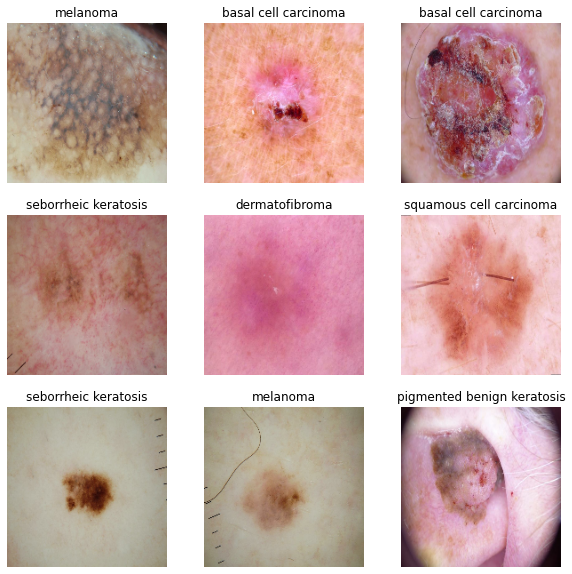

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for img,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
  
])

### Compile the model
 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
506/506 [==============================] - 2967s 890ms/step - loss: 1.4699 - accuracy: 0.4372 - val_loss: 1.0561 - val_accuracy: 0.6160
Epoch 2/20
506/506 [==============================] - 12s 23ms/step - loss: 0.9376 - accuracy: 0.6593 - val_loss: 0.7213 - val_accuracy: 0.7462
Epoch 3/20
506/506 [==============================] - 12s 23ms/step - loss: 0.6041 - accuracy: 0.7869 - val_loss: 0.5931 - val_accuracy: 0.7853
Epoch 4/20
506/506 [==============================] - 12s 23ms/step - loss: 0.3990 - accuracy: 0.8587 - val_loss: 0.4218 - val_accuracy: 0.8424
Epoch 5/20
506/506 [==============================] - 12s 23ms/step - loss: 0.2912 - accuracy: 0.8960 - val_loss: 0.3925 - val_accuracy: 0.8784
Epoch 6/20
506/506 [==============================] - 12s 23ms/step - loss: 0.2412 - accuracy: 0.9104 - val_loss: 0.2809 - val_accuracy: 0.9051
Epoch 7/20
506/506 [==============================] - 12s 23ms/step - loss: 0.1869 - accuracy: 0.9290 - val_loss: 0.3533 - val_accura

### Visualizing training results

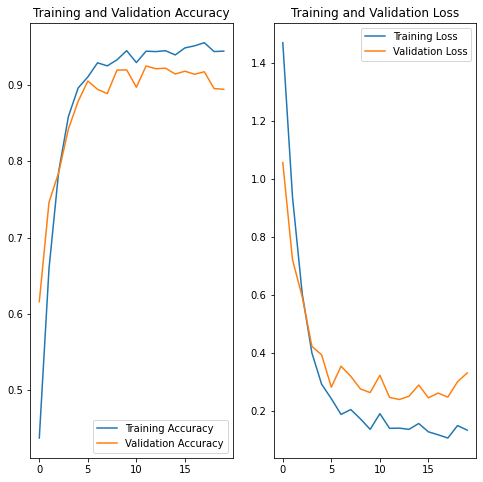

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Inference from Model 1:
As we can see from the plots, training accuracy and validation accuracy are closed and the model has achieved around 90% accuracy on the validation set.



In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

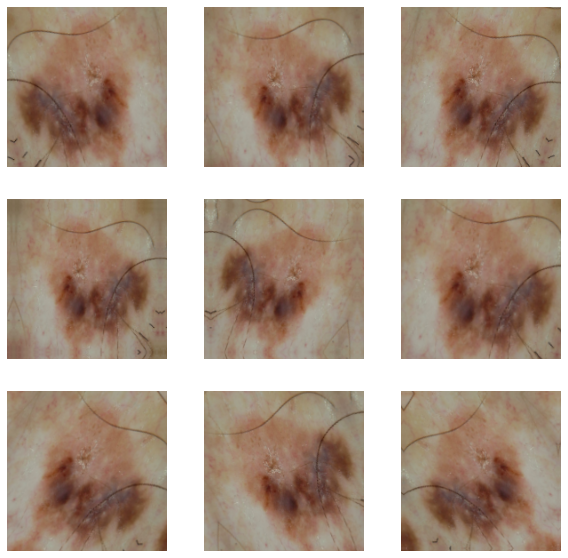

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [22]:
## Your code goes here, note: train your model for 20 epochs
## Training your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
506/506 [==============================] - 15s 26ms/step - loss: 1.5700 - accuracy: 0.4017 - val_loss: 1.3564 - val_accuracy: 0.4764
Epoch 2/20
506/506 [==============================] - 13s 26ms/step - loss: 1.2757 - accuracy: 0.5070 - val_loss: 1.2283 - val_accuracy: 0.5382
Epoch 3/20
506/506 [==============================] - 13s 26ms/step - loss: 1.1134 - accuracy: 0.5701 - val_loss: 0.9375 - val_accuracy: 0.6444
Epoch 4/20
506/506 [==============================] - 13s 26ms/step - loss: 1.0007 - accuracy: 0.6195 - val_loss: 0.9221 - val_accuracy: 0.6447
Epoch 5/20
506/506 [==============================] - 13s 26ms/step - loss: 0.8894 - accuracy: 0.6613 - val_loss: 0.9123 - val_accuracy: 0.6511
Epoch 6/20
506/506 [==============================] - 13s 26ms/step - loss: 0.7973 - accuracy: 0.7006 - val_loss: 0.7086 - val_accuracy: 0.7398
Epoch 7/20
506/506 [==============================] - 13s 26ms/step - loss: 0.7145 - accuracy: 0.7306 - val_loss: 0.7210 - val_accuracy:

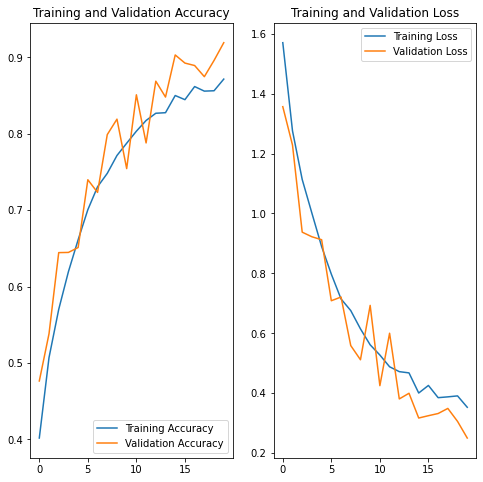

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
from pathlib import Path

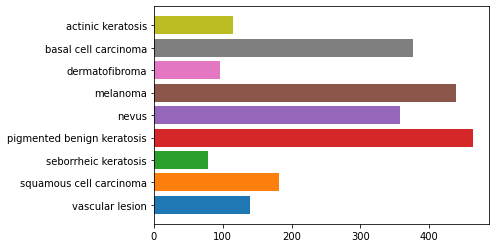

In [25]:
import os
path = '/content/gdrive/MyDrive/project/Train'
mn = 0
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # get all directories 
for folder in folders:
    contents = os.listdir(os.path.join(path,folder)) # get list of contents
    if len(contents) >= mn: # if greater than the limit, print folder and number of contents
        plt.barh(folder,len(contents))

### Write your findings here

In [26]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
!pip install Augmentor

In [27]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
path_to_training_dataset='/content/gdrive/MyDrive/project'
path_to_training_dataset = path_to_training_dataset + "/Train"
print(path_to_training_dataset)

/content/gdrive/MyDrive/project/Train



### Create the model, compile and train the model


In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.



Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/project/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA2900A7450>: 100%|██████████| 500/500 [00:20<00:00, 24.63 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/project/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3203A6990>: 100%|██████████| 500/500 [00:21<00:00, 23.75 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/project/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3203A6C10>: 100%|██████████| 500/500 [00:21<00:00, 22.79 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/project/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA3202A7750>: 100%|██████████| 500/500 [01:43<00:00,  4.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/project/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7FA320365390>: 100%|██████████| 500/500 [01:23<00:00,  5.96 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/project/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA320356B10>: 100%|██████████| 500/500 [00:17<00:00, 27.85 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/project/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA320462A90>: 100%|██████████| 500/500 [00:40<00:00, 12.43 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/project/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA28C1C7090>: 100%|██████████| 500/500 [00:18<00:00, 27.26 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/project/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA32047CB50>: 100%|██████████| 500/500 [00:18<00:00, 26.93 Samples/s]


In [29]:
data_dir_train = pathlib.Path(path_to_training_dataset)

In [30]:
print(data_dir_train)

/content/gdrive/MyDrive/project/Train


In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

22500


In [32]:
import glob

In [33]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/project/Train/vascular lesion/output/vascular lesion_original_ISIC_0029877.jpg_a4930a0c-9eb8-4d94-81c7-ac30420978f6.jpg',
 '/content/gdrive/MyDrive/project/Train/vascular lesion/output/vascular lesion_original_ISIC_0026713.jpg_9a4fdb2f-ce3e-4d13-93ac-3c8326ca06ee.jpg',
 '/content/gdrive/MyDrive/project/Train/vascular lesion/output/vascular lesion_original_ISIC_0031217.jpg_ae78464d-ea3a-46ae-b532-e57a62ff7222.jpg',
 '/content/gdrive/MyDrive/project/Train/vascular lesion/output/vascular lesion_original_ISIC_0026336.jpg_e5e0737d-59b7-4cfd-a86a-2ddcab559854.jpg',
 '/content/gdrive/MyDrive/project/Train/vascular lesion/output/vascular lesion_original_ISIC_0033158.jpg_7094c875-721c-44aa-ba1f-b5edfec3bab5.jpg',
 '/content/gdrive/MyDrive/project/Train/vascular lesion/output/vascular lesion_original_ISIC_0025677.jpg_35a26a17-6c0f-4632-bac0-470300622f8d.jpg',
 '/content/gdrive/MyDrive/project/Train/vascular lesion/output/vascular lesion_original_ISIC_0033844.jpg_86924a1

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '','output', '.jpg'))]
lesion_list_new

[]

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

### Compiling the model

In [38]:
## Your code goes here
batch_size = 32
img_height = 180
img_width = 180

In [39]:
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 24739 files belonging to 9 classes.
Using 19792 files for training.


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24739 files belonging to 9 classes.
Using 4947 files for validation.


In [41]:
## your code goes here

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.20326814 0.94771254


In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [43]:
epochs= 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
619/619 [==============================] - 119s 187ms/step - loss: 0.3584 - accuracy: 0.8712 - val_loss: 0.2560 - val_accuracy: 0.9102
Epoch 2/30
619/619 [==============================] - 94s 150ms/step - loss: 0.3293 - accuracy: 0.8811 - val_loss: 0.2259 - val_accuracy: 0.9185
Epoch 3/30
619/619 [==============================] - 92s 148ms/step - loss: 0.3456 - accuracy: 0.8774 - val_loss: 0.2021 - val_accuracy: 0.9329
Epoch 4/30
619/619 [==============================] - 92s 148ms/step - loss: 0.3101 - accuracy: 0.8853 - val_loss: 0.1997 - val_accuracy: 0.9295
Epoch 5/30
619/619 [==============================] - 92s 147ms/step - loss: 0.3120 - accuracy: 0.8869 - val_loss: 0.2432 - val_accuracy: 0.9109
Epoch 6/30
619/619 [==============================] - 93s 149ms/step - loss: 0.2983 - accuracy: 0.8903 - val_loss: 0.1966 - val_accuracy: 0.9315
Epoch 7/30
619/619 [==============================] - 93s 149ms/step - loss: 0.2820 - accuracy: 0.8963 - val_loss: 0.2580 - val_a

### Visualizing the results

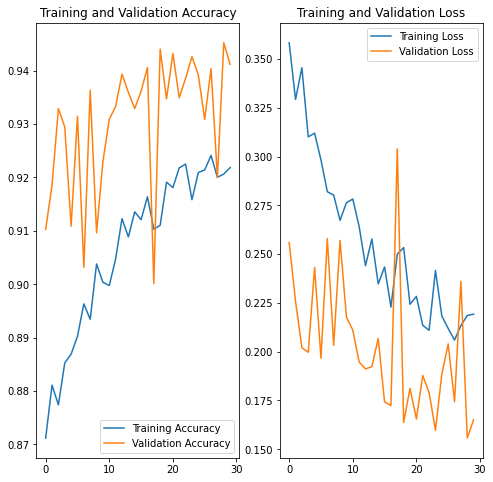

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()